In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import Omega as o

sns.set_style('white')
sns.set_palette('Blues_r')
plt.rcParams['axes.edgecolor'] = 'k'

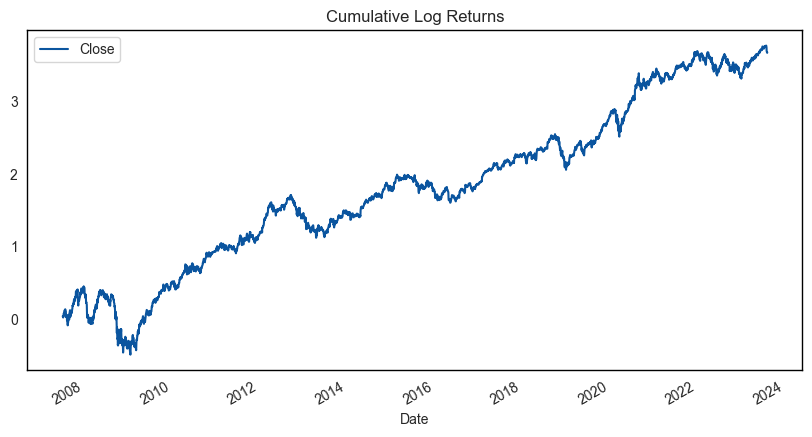

In [116]:
def compute_features(stock_data, lookback):
    prices = stock_data['Close']
    volume = stock_data['Volume']
    log_returns = np.log(prices).diff().fillna(0)
    roc_2q = prices.pct_change(126)
    roc_1q = prices.pct_change(63)
    volatility = log_returns.rolling(lookback).std()
    features = [prices, volume, log_returns, roc_2q, roc_1q, volatility]
    features = pd.concat(features, axis=1).dropna()
    log_returns.name = stock_data
    return log_returns.loc[features.index], features

start = '2007-01-01'
end = '2023-08-10'
stocks = ['AAPL']
stock_data = yf.download(stocks, start, end, progress=False)

lookback = 50
returns, data = compute_features(stock_data, lookback)

returns.cumsum().plot(figsize=(10, 5))
plt.legend()
plt.title('Cumulative Log Returns')
plt.show()

In [114]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

n_clusters = 3
kmeans = KMeans(n_clusters, n_init='auto')
kmeans.fit(data)

regimes = data.copy()
regimes['regime'] = kmeans.labels_

In [ ]:
# Parameters
sequence_length = 20
forecast_length = 3
bull_threshold = 0.01
bear_threshold = -0.01

# Create sequences and labels
sequences = []
labels = []

for i in range(len(returns) - sequence_length - forecast_length + 1):
    sequence = returns.iloc[i:i+sequence_length].values
    subsequent_return = returns.iloc[i+sequence_length:i+sequence_length+forecast_length].mean().mean()
    
    if subsequent_return > bull_threshold:
        label = 0  # Bull Market
    elif subsequent_return < bear_threshold:
        label = 1  # Bear Market
    else:
        label = 2  # Sideways Market
    
    sequences.append(sequence)
    labels.append(label)

sequences = np.array(sequences)
labels = np.array(labels)

# Split data into training and testing
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3224, 20, 3), (807, 20, 3), (3224,), (807,))

<Axes: xlabel='Date'>

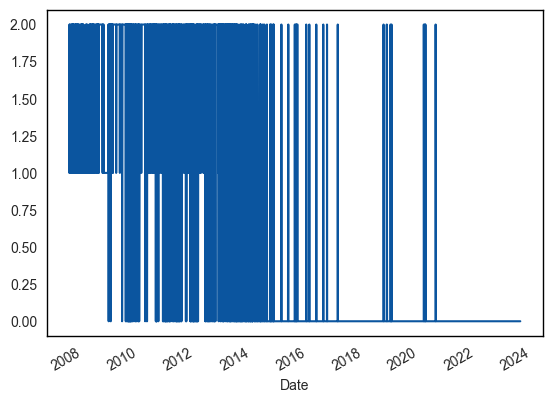

In [97]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

n_clusters = 3
kmeans = KMeans(n_clusters, n_init='auto')
kmeans.fit(data)

regimes = returns.copy()
regimes['regime'] = kmeans.labels_

regimes.groupby('regime')

In [71]:
# Parameters
sequence_length = 20
forecast_length = 3
bull_threshold = 0.01
bear_threshold = -0.01

# Create sequences and labels
sequences = []
labels = []

for i in range(len(returns) - sequence_length - forecast_length + 1):
    sequence = returns.iloc[i:i+sequence_length].values
    subsequent_return = returns.iloc[i+sequence_length:i+sequence_length+forecast_length].mean().mean()
    
    if subsequent_return > bull_threshold:
        label = 0  # Bull Market
    elif subsequent_return < bear_threshold:
        label = 1  # Bear Market
    else:
        label = 2  # Sideways Market
    
    sequences.append(sequence)
    labels.append(label)

sequences = np.array(sequences)
labels = np.array(labels)

# Split data into training and testing
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3224, 20, 3), (807, 20, 3), (3224,), (807,))

In [37]:
X_train

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.19531511e-02,  1.24225470e-02,  2.49322660e-03],
        [-7.14681656e-03, -9.11475242e-03, -8.33507041e-03],
        ...,
        [ 6.53756811e-03,  1.21013221e-03, -4.63849854e-03],
        [-4.54855980e-03,  3.62151991e-03,  1.42500971e-02],
        [ 2.10194839e-03,  6.15669269e-03,  1.48355999e-02]],

       [[ 2.19531511e-02,  1.24225470e-02,  2.49322660e-03],
        [-7.14681656e-03, -9.11475242e-03, -8.33507041e-03],
        [ 4.92615286e-03, -1.65252958e-03,  3.34238549e-03],
        ...,
        [-4.54855980e-03,  3.62151991e-03,  1.42500971e-02],
        [ 2.10194839e-03,  6.15669269e-03,  1.48355999e-02],
        [-1.16150289e-02,  3.13876764e-03,  5.48266071e-03]],

       [[-7.14681656e-03, -9.11475242e-03, -8.33507041e-03],
        [ 4.92615286e-03, -1.65252958e-03,  3.34238549e-03],
        [ 7.97995582e-02, -3.76591530e-03, -4.17975031e-03],
        ...,
        [ 2.10194839e-03,  6.15669269e-03,

Epoch [20/100], Loss: 0.5221
Epoch [40/100], Loss: 0.5107
Epoch [60/100], Loss: 0.5070
Epoch [80/100], Loss: 0.5065
Epoch [100/100], Loss: 0.5063


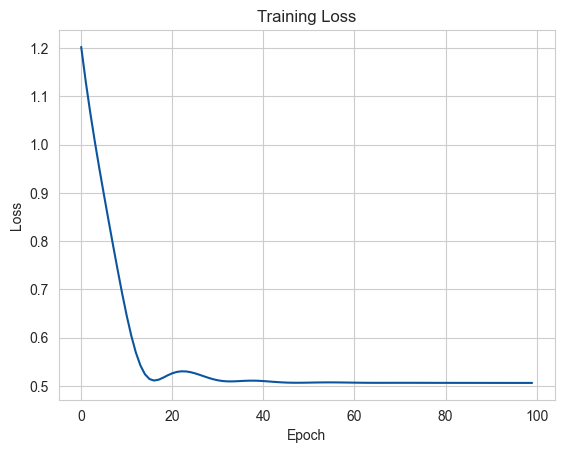

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the RNN model
class MarketRegimeRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(MarketRegimeRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[-1]
hidden_size = 50
num_layers = 2
num_classes = 3
learning_rate = 0.001
num_epochs = 100
batch_size = 10

# Convert data to tensors
train_data = torch.tensor(X_train, dtype=torch.float32).to(device)
train_labels = torch.tensor(y_train, dtype=torch.long).to(device)
test_data = torch.tensor(X_test, dtype=torch.float32).to(device)
test_labels = torch.tensor(y_test, dtype=torch.long).to(device)

# Define model, loss, and optimizer
model = MarketRegimeRNN(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
losses = []
for epoch in range(num_epochs):
    outputs = model(train_data)
    loss = criterion(outputs, train_labels)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [33]:
model.eval()
with torch.no_grad():
    predictions = model(test_data)
    predicted_labels = torch.argmax(predictions, dim=1)
predictions

# n_stocks = len(stocks)
# # Define trading strategy
# initial_portfolio_value = 1000  # Initial investment
# portfolio_value = initial_portfolio_value
# stock_positions = np.zeros(n_stocks)
# stock_positions

# for i in range(len(predicted_labels)):
#     if predicted_labels[i] == 0:  # Bull Market
#         stock_positions += portfolio_value / n_stocks / prices.iloc[i + train_size + sequence_length - 1].values
#         portfolio_value = 0
#     elif predicted_labels[i] == 1:  # Bear Market
#         portfolio_value += np.sum(stock_positions * prices.iloc[i + train_size + sequence_length - 1].values)
#         stock_positions = np.zeros(n_stocks)
#     # For sideways market, we just hold our current position

# # Calculate final portfolio value at the end of the test period
# portfolio_value += np.sum(stock_positions * prices.iloc[-1].values)

# initial_portfolio_value, portfolio_value


tensor([[-0.9720, -0.8998,  1.5420],
        [-0.9760, -0.9018,  1.5534],
        [-0.9720, -0.9010,  1.5432],
        ...,
        [-0.9697, -0.8991,  1.5407],
        [-0.9714, -0.8988,  1.5441],
        [-0.9684, -0.8975,  1.5375]])